In [316]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [286]:
def draw_plots(df, column):
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df.index, df[column])

    # Define the locator as before to control tick frequency
    locator = mdates.MonthLocator() # Explicitly locate ticks at the start of each month
    
    # Replace ConciseDateFormatter with the explicit DateFormatter
    formatter = mdates.DateFormatter('%b %Y') # Format: Abbreviated Month and Full Year

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    fig.autofmt_xdate(rotation=45) # rotation for better spacing
    
    plt.show()

def draw_plots_grid(df, columns,  windows=[7, 28],save_path = "",nrows = 2, ncols = 2):

    df.index = pd.to_datetime(df.index)

    # Create a 2x2 grid of subplots. 'ax' is now a 2x2 NumPy array.
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

    # Flatten the 2D array of axes to a 1D array for easy iteration.
    axes_flat = ax.flatten()

    # Loop through each column and its corresponding subplot axis.
    for i, col_name in enumerate(columns):
        # Select the current axis from the flattened array.
        current_ax = axes_flat[i]
        
        # Plot the data on the current axis.
        current_ax.plot(df.index, df[col_name], label = "original")
        colors = ['orange', 'red', 'green'] 
        for j, window_size in enumerate(windows):
            rolling_mean = df[col_name].rolling(window=window_size).mean()
            current_ax.plot(df.index, rolling_mean, label=f'{window_size}-Day Avg', color=colors[j], linewidth=2 + j)
        
        # Set a title for the individual subplot.
        current_ax.set_title(f"Time Series of {col_name}")

        # Define locator and formatter for THIS specific subplot's x-axis.
        locator = mdates.MonthLocator()
        formatter = mdates.DateFormatter('%b %Y')

        current_ax.xaxis.set_major_locator(locator)
        current_ax.xaxis.set_major_formatter(formatter)
        current_ax.legend()
        current_ax.grid(True, linestyle='--', alpha=0.6)

    fig.tight_layout(pad=3.0)
    
    for i in range(len(columns), len(axes_flat)):
        axes_flat[i].set_visible(False)

    if(save_path):
        plt.savefig(save_path, dpi = 300)
    plt.show()


In [320]:
def analyze_gaps(df, column_name):
    """
    Analyzes the structure of contiguous missing value gaps in a DataFrame column.
    """
    is_missing = df[column_name].isnull()
    if not is_missing.any():
        return {
            "num_gaps":0,
            "max_gap_length":0,
            "avg_gap_length":0
        }
        
    gap_starts = is_missing.ne(is_missing.shift()).cumsum()
    gaps = is_missing.groupby(gap_starts).sum()
    actual_gaps = gaps[gaps > 0]
    if actual_gaps.empty:
        return {
            'num_gaps': 0,
            'max_gap_length': 0,
            'avg_gap_length': 0.0
        }
        
    return {
        'num_gaps': len(actual_gaps),
        'max_gap_length': actual_gaps.max(),
        'avg_gap_length': actual_gaps.mean()
    }

In [322]:
def plot_missing_values_heatmap(df, save_path= ""):
    plt.figure(figsize=(20, 10))
    sns.heatmap(df.isnull(), cbar = False, yticklabels = False, cmap = "viridis")
    plt.title('Heatmap of Missing Values by Time', fontsize=16)
    plt.xlabel('Features')
    plt.ylabel('Time (Chronological Order)')
    if(save_path):
        plt.savefig(f"./figures/{save_path}")
    plt.show()

def plot_missing_values_correlation(df, save_path= ""):
    numeric_columns = df.select_dtypes(include = np.number).columns
    plt.figure(figsize=(18, 15))
    sns.heatmap(df[numeric_columns].isnull().corr(), cmap='coolwarm')
    plt.title('Correlation Matrix of Missing Values')
    if(save_path):
        plt.savefig(f"./figures/{save_path}")
    plt.show()

In [321]:
def get_missing_proportion(df):
    return pd.DataFrame({
    "missing_count":df.isnull().sum(),
    "missing_percent": (df.isnull().sum() / len(df)) * 100
}).sort_values(by = "missing_count", ascending= False)

In [323]:
df = pd.read_csv("./cleaned_data/p07.csv", index_col="dateTime")
df.index = pd.to_datetime(df.index)
core_features = ["avg_daily_heart_rate",
                 "steps_sum",
                "very_active_minutes_sum",
               "moderately_active_minutes_sum",
                "sedentary_minutes_sum",
                "lightly_active_minutes_sum",
                "avg_overall_sleep_score",
                "total_rem_sleep_minutes",
                "total_deep_sleep_minutes",
                "avg_restlessness",
                "soreness",
                "sleep_quality"
       ]
sleep_features = ["sleep_quality", "total_deep_sleep_minutes","total_rem_sleep_minutes", "avg_overall_sleep_score"]
core_target = ["mood","stress","fatigue","readiness"]

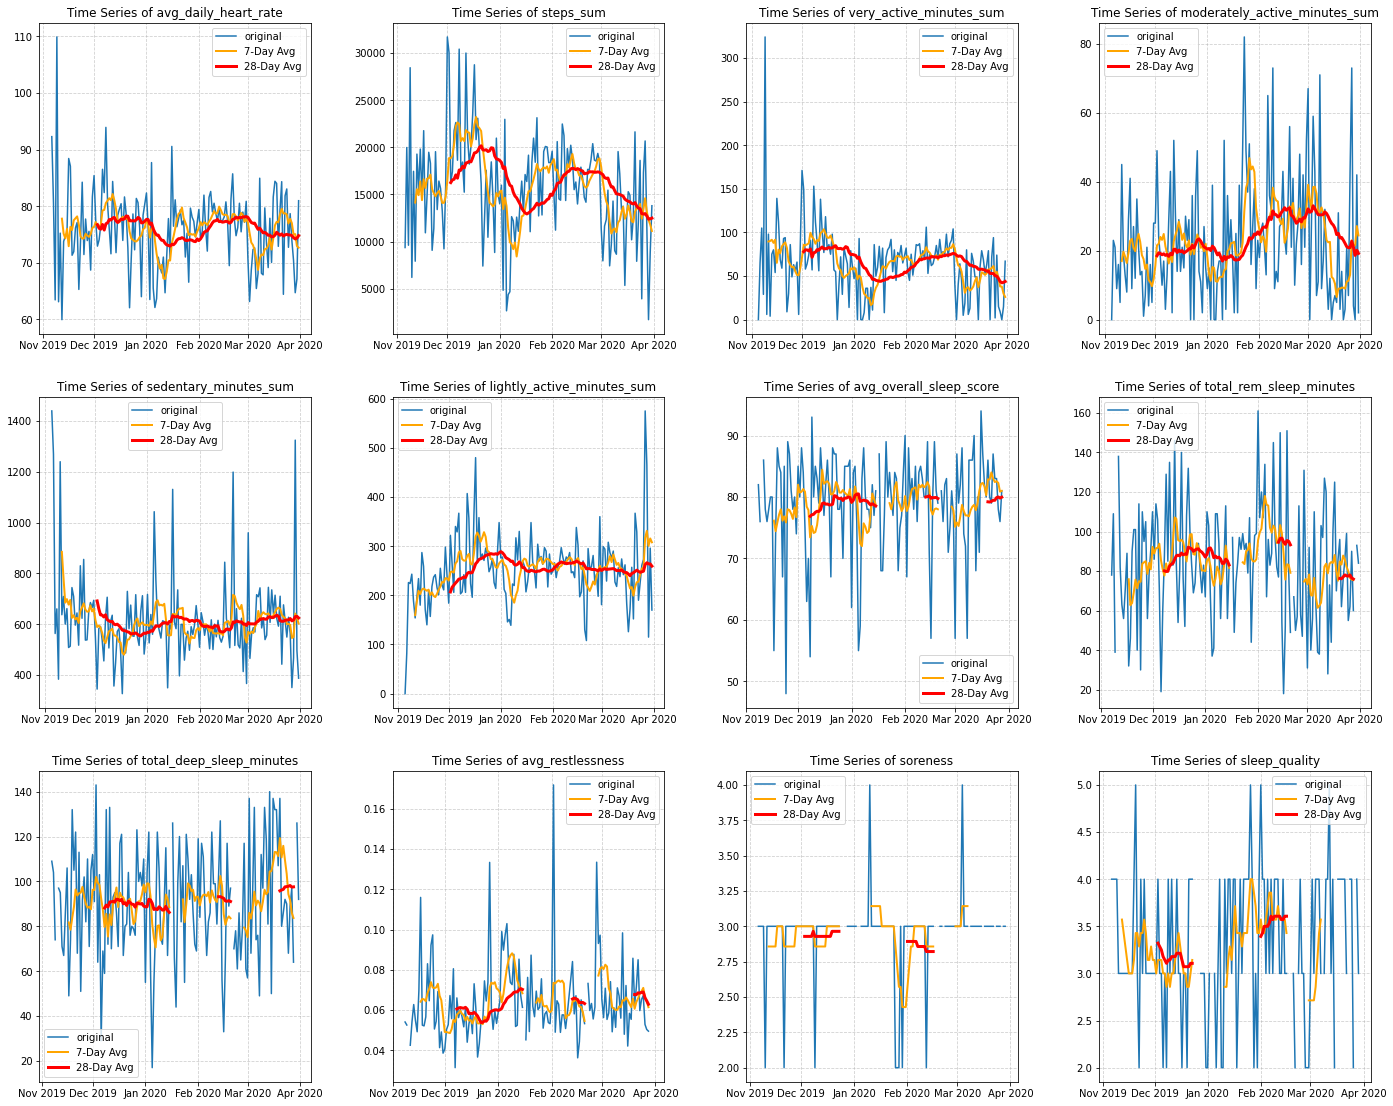

In [324]:
draw_plots_grid(df, core_features,nrows = 3, ncols = 4)

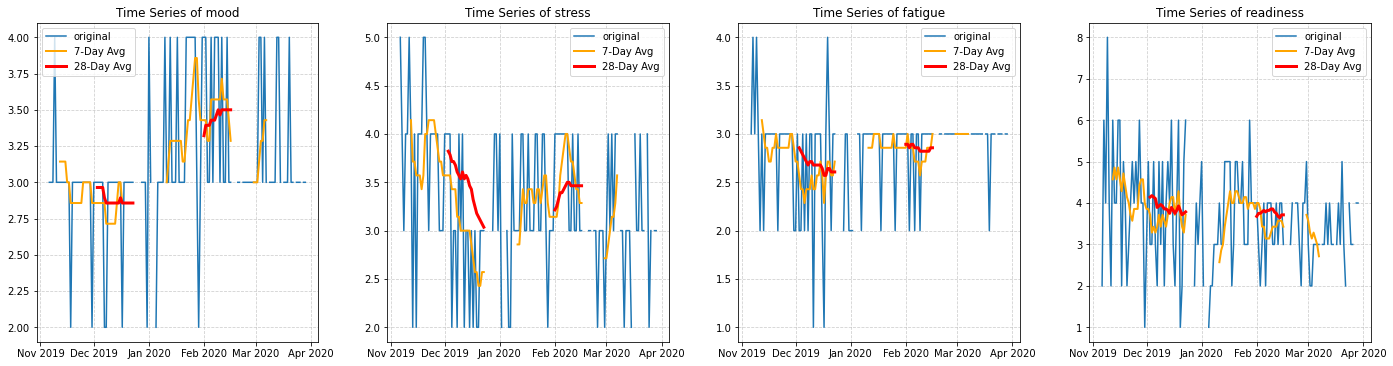

In [325]:
draw_plots_grid(df, core_target,save_path="./figures/missing_data.png",nrows = 3, ncols = 4)

In [326]:
gap_analysis_results = {col:analyze_gaps(df,col) for col in df.columns}

gap_summary = pd.DataFrame.from_dict(gap_analysis_results, orient= "index")
missing_analysis = get_missing_proportion(df)
full_missing_analysis = pd.concat([missing_analysis, gap_summary], axis=1)
# full_missing_analysis.to_csv("cleaned_data/missing_analysis.csv")

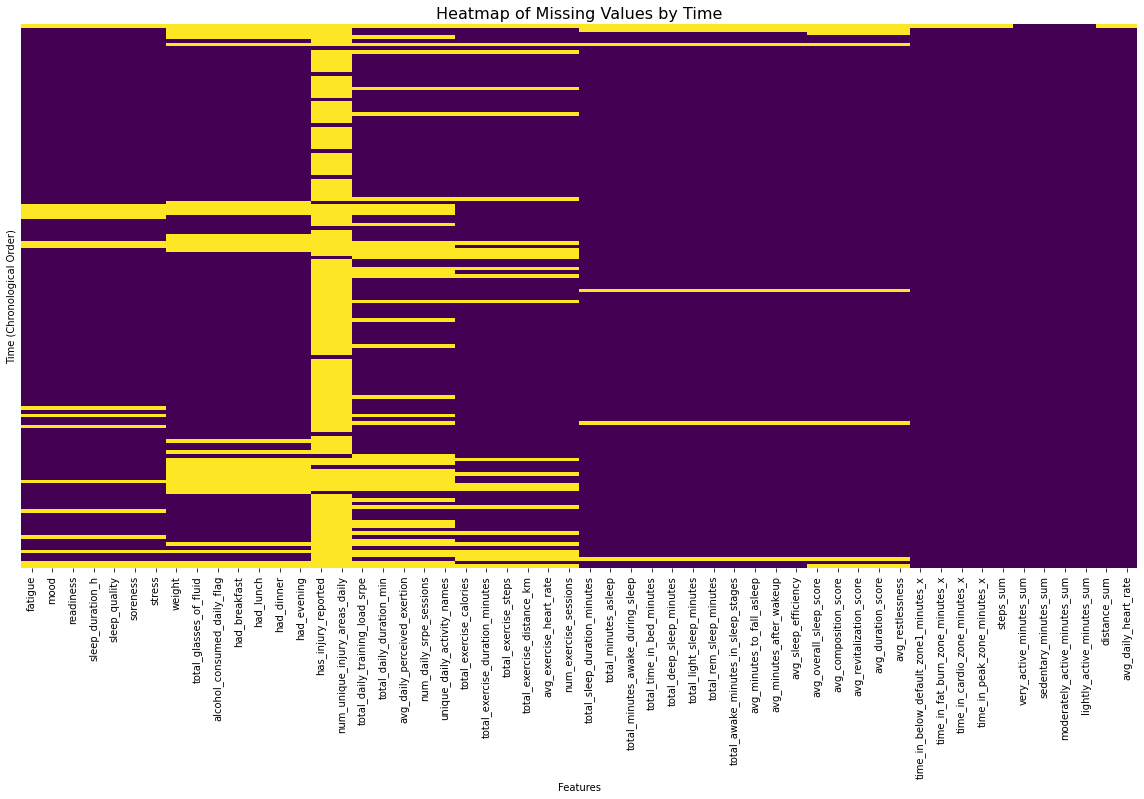

In [327]:
plot_missing_values_heatmap(df, save_path="missing_values.png")

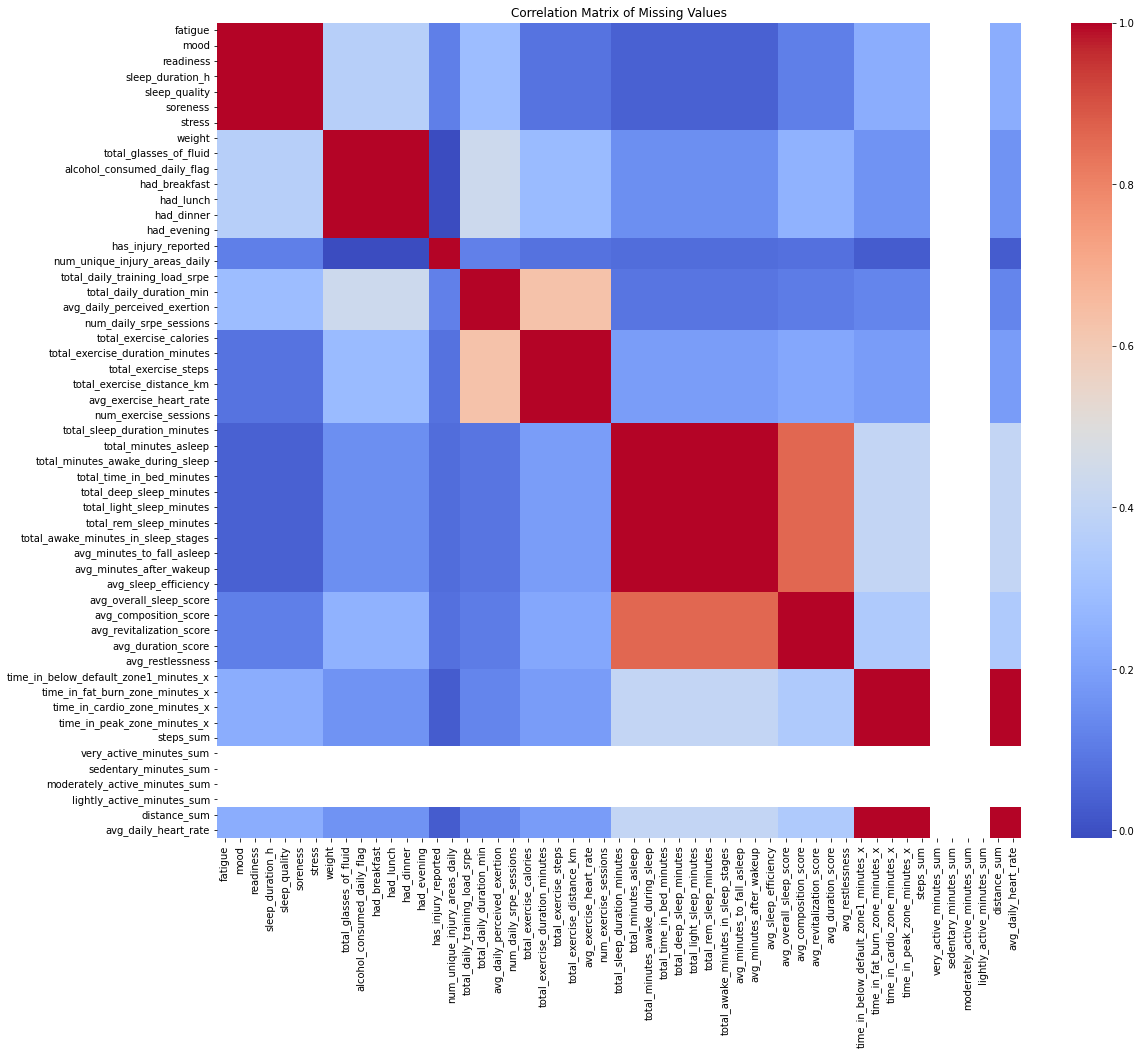

In [328]:
plot_missing_values_correlation(df,save_path="missing_values_corr.png")

In [329]:
full_missing_analysis

,missing_count,missing_percent,num_gaps,max_gap_length,avg_gap_length
has_injury_reported,134,90.540541,15,26,8.933333
num_unique_injury_areas_daily,134,90.540541,15,26,8.933333
total_daily_duration_min,45,30.405405,26,6,1.730769
num_daily_srpe_sessions,45,30.405405,26,6,1.730769
avg_daily_perceived_exertion,45,30.405405,26,6,1.730769
total_daily_training_load_srpe,45,30.405405,26,6,1.730769
unique_daily_activity_names,45,30.405405,26,6,1.730769
weight,30,20.270270,10,10,3.000000
total_glasses_of_fluid,30,20.270270,10,10,3.000000
alcohol_consumed_daily_flag,30,20.270270,10,10,3.000000


In [330]:
df.drop(["num_unique_injury_areas_daily","has_injury_reported"], axis = 1, inplace = True)

In [331]:
sleep_data_columns = ["avg_overall_sleep_score",
                      "total_minutes_asleep",
                     "total_rem_sleep_minutes",
                     "total_deep_sleep_minutes",
                     "avg_restlessness"]

exercise_data_columns = [
    "total_exercise_duration_minutes",
    "avg_exercise_heart_rate",
    "num_exercise_sessions",    
]

physiological_signals_columns = [
    "avg_daily_heart_rate",
    "sedentary_minutes_sum",
    "lightly_active_minutes_sum",
    "very_active_minutes_sum",
    'time_in_below_default_zone1_minutes_x',
    'time_in_fat_burn_zone_minutes_x',
    'time_in_cardio_zone_minutes_x',
    'time_in_peak_zone_minutes_x'
]

srpe_columns = [
    "total_daily_training_load_srpe"
]

lifestyle_columns = [
    "alcohol_consumed_daily_flag",
    "weight",
    'had_breakfast',
    'had_lunch',
    'had_dinner',
    'had_evening',
    
]

core_targets_columns = [
    'fatigue',
    'mood',
    'readiness',
    'soreness',
    'stress'
]

all_columns = sleep_data_columns + exercise_data_columns + physiological_signals_columns + srpe_columns + lifestyle_columns + core_targets_columns

# Missing Values

**Sleep Block**
The gaps are few and relatively short (max gap of 3 days). The best method here is time-based interpolation. This will create a smooth, plausible continuous signal, which is essential for calculating clean moving averages and for use in daily models. This directly fixes the broken plots you encountered earlier.

Action: Apply .interpolate(method='time') to all columns in the sleep data block.

In [332]:
df[sleep_data_columns] = df[sleep_data_columns].interpolate(method = "time")



**Logged Exercise Block**
The missingness in these columns does not mean "unknown"; it means "an exercise/session was not logged". Imputing with a mean or median would be logically wrong, as it would invent exercise on rest days. The correct representation is zero.

Action: Fill all NaN values in these two blocks with 0. This correctly transforms the data to represent "0 minutes of logged exercise" or a "daily training load of 0".

In [333]:
df[exercise_data_columns] = df[exercise_data_columns].fillna(0)

In [334]:
df[srpe_columns] = df[srpe_columns].fillna(0)

**Self-Report & Lifestyle Block**
1) Core Targets (mood, stress, fatigue, readiness, soreness):
   As established, this is likely MNAR data. Do not impute these columns. They represent your ground truth and should remain unaltered. Your models will be trained only on the days these values are present.

2) Lifestyle Factors (weight, total_glasses_of_fluid, had_breakfast, etc.):
    Since these are part of the same "daily journal event" and will be used as predictor features, filling them with 0 for binary flags (alcohol_consumed_daily_flag) or applying a forward-fill (ffill) for values like weight is a reasonable approach for now. This assumes that if a user did not log these, the event did not occur or the value was stable. This is a pragmatic choice to prepare the data for modeling, but the underlying assumption should be noted.

In [335]:
df[lifestyle_columns].isna().sum()

alcohol_consumed_daily_flag    30
weight                         30
had_breakfast                  30
had_lunch                      30
had_dinner                     30
had_evening                    30
dtype: int64

In [336]:
df["weight"] = df["weight"].ffill()

In [337]:
df["alcohol_consumed_daily_flag"] = df["alcohol_consumed_daily_flag"].fillna(0)

In [338]:
def fill_with_zero(df):
    return df.fillna(0)
        

In [339]:
df["had_lunch"] = df["had_lunch"].fillna(0)
print(df["had_dinner"].value_counts())
print(df["had_evening"].value_counts())
print(df["had_breakfast"].value_counts())
print(df["weight"].value_counts())

had_dinner
1.0    109
0.0      9
Name: count, dtype: int64
had_evening
1.0    59
0.0    59
Name: count, dtype: int64
had_breakfast
1.0    74
0.0    44
Name: count, dtype: int64
weight
66.0    54
67.0    51
68.0    39
Name: count, dtype: int64


In [340]:
df[["had_lunch","had_dinner","had_breakfast","had_evening"]] = df[["had_lunch","had_dinner","had_breakfast","had_evening"]].apply(fill_with_zero)

In [341]:
df[all_columns].isna().sum()

avg_overall_sleep_score                   3
total_minutes_asleep                      2
total_rem_sleep_minutes                   2
total_deep_sleep_minutes                  2
avg_restlessness                          3
total_exercise_duration_minutes           0
avg_exercise_heart_rate                   0
num_exercise_sessions                     0
avg_daily_heart_rate                      1
sedentary_minutes_sum                     0
lightly_active_minutes_sum                0
very_active_minutes_sum                   0
time_in_below_default_zone1_minutes_x     1
time_in_fat_burn_zone_minutes_x           1
time_in_cardio_zone_minutes_x             1
time_in_peak_zone_minutes_x               1
total_daily_training_load_srpe            0
alcohol_consumed_daily_flag               0
weight                                    4
had_breakfast                             0
had_lunch                                 0
had_dinner                                0
had_evening                     

**Physiological Data**

In [342]:
df[physiological_signals_columns].isna().sum()

avg_daily_heart_rate                     1
sedentary_minutes_sum                    0
lightly_active_minutes_sum               0
very_active_minutes_sum                  0
time_in_below_default_zone1_minutes_x    1
time_in_fat_burn_zone_minutes_x          1
time_in_cardio_zone_minutes_x            1
time_in_peak_zone_minutes_x              1
dtype: int64

In [350]:
df.dropna(subset=['avg_overall_sleep_score', 'weight'], inplace=True)

In [352]:
df.shape

(144, 52)

Step 2: Engineer Features to Capture Dynamics and Relationships
Raw daily data is noisy. The real insights come from features that describe trends, changes, and relationships over time.

Recalculate Moving Averages: Now that the sleep data is continuous, recalculate your 7-day and 28-day moving averages for sleep, heart rate, and activity metrics. These will now be complete and serve as reliable indicators of short-term and long-term trends.

Engineer "Delta" and "Deviation" Features: The most powerful signals are often not the absolute values, but the changes relative to a baseline.

Action: Create features like heart_rate_deviation_from_28day_avg (i.e., daily_hr - hr_28_day_avg) or sleep_score_change_from_yesterday. These features are excellent for identifying anomalies and flagging days that are physiologically unusual for the individual.
Engineer Lagged Features for Predictive Modeling: To model the effect of one day's events on the next day's mood, you must create lagged features.

Action: Create columns like sleep_score_lag1, active_minutes_lag1, and alcohol_consumed_lag1. These represent yesterday's values and will be the primary predictors for today's mood or stress.

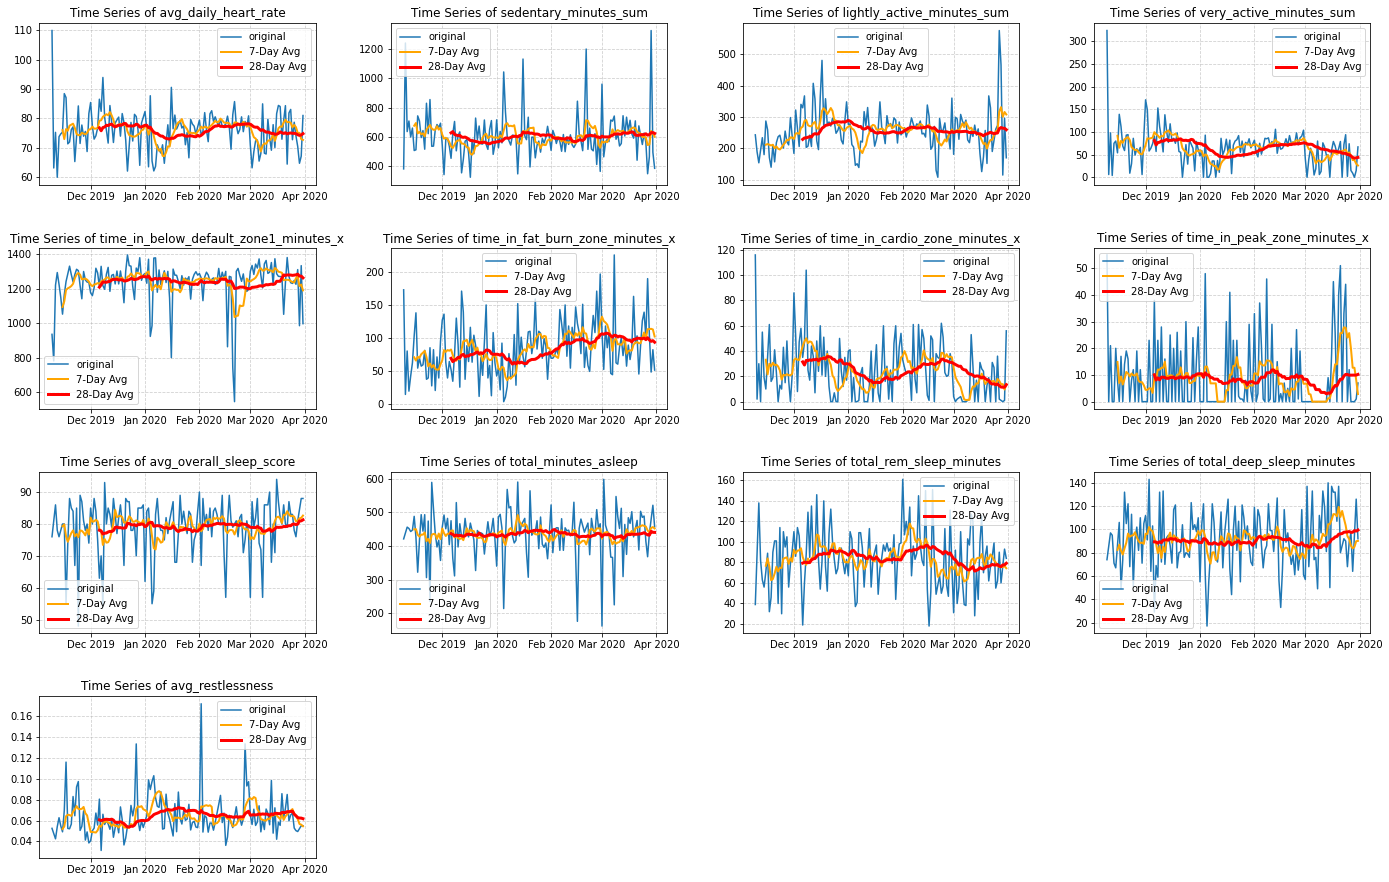

In [356]:
draw_plots_grid(df, physiological_signals_columns + sleep_data_columns,nrows = 5, ncols = 4)

Step 3: Conduct Initial Driver Analysis
With a clean and feature-rich dataset, you can now move from diagnosing data to extracting insights. The goal is to understand what factors are most impactful for this individual's mental health.

Action: Run a Feature Importance Analysis. Use a tree-based model, such as a RandomForestRegressor, which is robust and excellent for this purpose.
Set up the model:
Your target variable (y) will be a column like mood.
Your feature set (X) will include the "Physiological Bedrock" features, the newly created "Deviation" features, and the "Lagged" features.
Crucially, you must train the model only on the rows where mood is not null.
The Outcome: The goal is not to achieve a perfect prediction score. The primary output you need is the feature importance scores. This will give you a ranked list of which factors (e.g., sleep_score_lag1, sedentary_minutes, heart_rate_deviation) are the most powerful predictors of the target variable. This is a cornerstone clinical insight. <br>
Step 4: Begin Prototyping the Dashboard Views
All the previous steps feed directly into the design of your Power BI dashboard. You now have the clean data and engineered features ready to be visualized.

The "Long-Term Trends" View: This view will be built using the 28-day moving averages of key metrics like mood, stress, sleep score, and resting heart rate. These will provide a smooth, high-level overview of the user's progress over months.
The "Daily & Weekly Detail" View: This view will use the 7-day moving averages overlaid on the daily raw values. This is where you can visualize the relationships discovered in your driver analysis, such as plotting mood against sleep_score_lag1.
The "Flags & Anomalies" View: This view will be powered by your "Delta" and "Deviation" features. You can create KPI cards or a table that highlights significant events, such as "Heart rate was 15% above average today" or "Sleep score dropped more than 20 points from yesterday." This provides clinicians with immediate, actionable red flags.